Reference
- https://github.com/JoungheeKim 님의 논문구현 코드를 따라 단계별 Pytorch 코드 리뷰와 모델 구성을 파악하였습니다.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import easydict
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader, Dataset
from celluloid import Camera
import pandas as pd
import pickle
from typing import List
import warnings
warnings.filterwarnings('ignore')

# 1. Data Load

In [2]:
## 데이터 불러오기
df = pd.read_csv('sensor.csv', index_col=0)
## 데이터 확인
df.head(3)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


- 펌프에 부착된 52개의 센서로부터 계측된 값들을 2018년 4월 ~ 2018년 8월 까지 분 단위로 수집한 데이터
- 수집 기간내에 총 7번의 시스템 오류가 존재
- machine_status열로 시스템의 오류상태를 알 수 있음

# 2. PreProcess

각 컬럼의 데이터 타입이 object이므로 “timestamp” 컬럼은 datetime으로 “sensor” 컬럼은 숫자로 데이터 타입을 변경

In [3]:
## 데이터 Type 변경
df['date'] = pd.to_datetime(df['timestamp'])
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
del df['timestamp']

## date를 index로 변환
df = df.set_index('date')

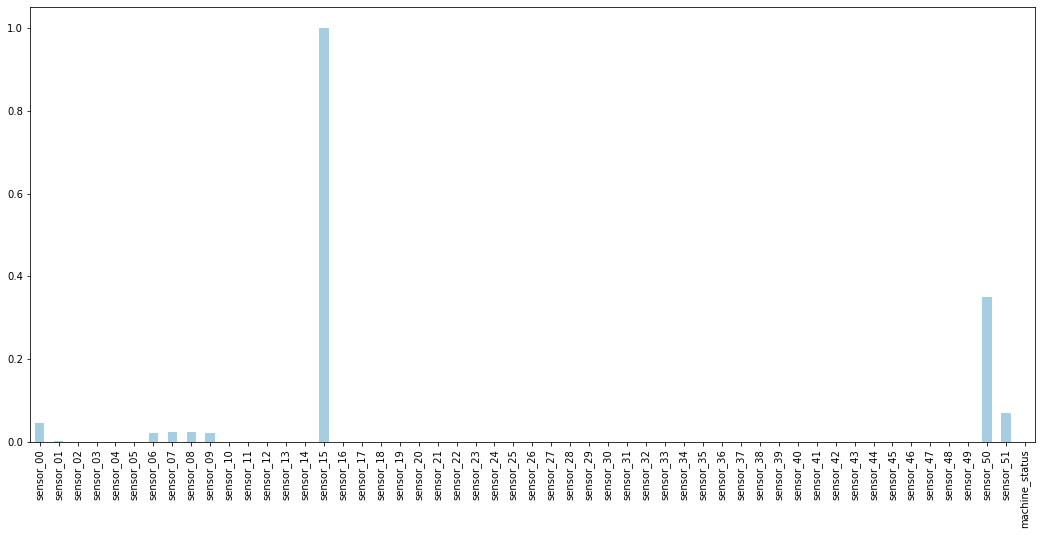

In [4]:
## 결측 변수 확인
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

- 센서 15는 모든 구간이 결측 데이터
- 센서 50은 결측 비율이 40% 이상
- 결측비율이 높은 데이터는 정확한 보간이 어려우며 모델의 성능을 하락시키므로 제거
- 나머지 10% 미만의 결측 비율을 갖고 있는 6개의 센서 데이터는 한 시점 이전 데이터를 이용하여 보간

In [5]:
## 중복된 데이터를 삭제
df = df.drop_duplicates()

## 센서 15번, 센서 50 은 삭제
del df['sensor_15']
del df['sensor_50']

## 이전 시점의 데이터로 보간
df = df.fillna(method='ffill')

In [6]:
len(df.columns)

51

# 3. Data Split & Normalization

In [7]:
normal_df = df[df['machine_status']=='NORMAL']
abnormal_df = df[df['machine_status']!='NORMAL']

In [8]:
## 시계열 데이터이고, 입력의 형태가 특정 길이(window size)의 sequence 데이터 이므로 shuffle은 사용하지 않습니다.
## Normal 데이터는 학습데이터, 파라미터 설정데이터, 검증용데이터, 실험용데이터의 비율을 7:1:1:1 로 나누어서 사용합니다.

interval_n = int(len(normal_df)/10)
normal_df1 = df.iloc[0:interval_n*7]
normal_df2 = df.iloc[interval_n*7:interval_n*8]
normal_df3 = df.iloc[interval_n*8:interval_n*9]
normal_df4 = df.iloc[interval_n*9:]

## abnormal 데이터는 검증용데이터, 실험용데이터의 비율을 5:5 로 나누어서 사용합니다.
interval_ab = int(len(abnormal_df)/2)
abnormal_df1 = df.iloc[0:interval_ab]
abnormal_df2 = df.iloc[interval_ab:]

In [9]:
## 데이터 정규화를 위하여 분산 및 평균 추출
mean_df = normal_df1.mean()
std_df = normal_df1.std()

- 모델은 입력(original data)과 출력(reconstructed data)의 차이인 를 이용하여 학습
- 각 센서데이터(변수)의 단위 차이가 크면 모델은 가장 큰 단위를 갖고 있는 특정 변수의 의존도가 높게 학습
- 특정 변수의 의존도를 없애고 모델을 robust하게 하기 위하여 데이터 정규화가 필요

# 4. Make Dataset

- 모델은 연속된 시계열 데이터를 이용해 비정상 점수를 산출해야 합니다. 데이터의 연속여부를 추출하기 위해서 make_data_idx 함수를 만듭니다. 

In [10]:
## 데이터를 불러올 때 index로 불러오기
def make_data_idx(dates, window_size=1):
    input_idx = []
    for idx in range(window_size-1, len(dates)):
        cur_date = dates[idx].to_pydatetime() # datetime.datetime(2018, 4, 1, 0, 0)이런 형식
        in_date = dates[idx - (window_size-1)].to_pydatetime()
        
        _in_period = (cur_date - in_date).days * 24 * 60 + (cur_date - in_date).seconds / 60
        
        ## 각 index가 1분 간격으로 떨어져 있는지를 확인합니다.
        if _in_period == (window_size-1):
            input_idx.append(list(range(idx - window_size+1, idx+1)))
    return input_idx

In [12]:
print(len(a))
print(len(df))

217444
217444


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [13]:
## pytorch의 Dataset을 상속받아 데이터를 구성
class TagDataset(Dataset):
    ## __init__ 메서드 안에서 self.속성에 값을 할당하여 속성 생성
    def __init__(self, input_size, df, mean_df=None, std_df = None, window_size=1):
        
        ## 변수 갯수
        self.input_size = input_size
        
        ## 복원할 sequence 길이
        self.window_size = window_size
        
        ## Summary용 데이터 Deep copy
        original_df = df.copy()
        
        ## 정규화
        if mean_df is not None and std_df is not None:
            sensor_columns = [item for item in df.columns if 'sensor_' in item]
            df[sensor_columns] = (df[sensor_columns]-mean_df)/std_df
        
        ## 연속한 index를 기준으로 학습에 사용합니다.
        dates = list(df.index)
        self.input_ids = make_data_idx(dates, window_size=window_size)
        
        ## sensor 데이터만 사용하여 reconstruct에 활용
        self.selected_column = [item for item in df.columns if 'sensor_' in item][:input_size]
        self.var_data = torch.tensor(df[self.selected_column].values, dtype=torch.float)
        
        ## Summary 용
        self.df = original_df.iloc[np.array(self.input_ids)[:, -1]]
        
    ## Dataset은 반드시 __len__ 함수를 만들어줘야함(데이터 길이)
    ## The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return len(self.input_ids)
    
    ## Dataset은 반드시 __getitem__ 함수를 만들어줘야함
    ## torch 모듈은 __getitem__ 을 호출하여 학습할 데이터를 불러옴.
    ## The __getitem__ function loads and returns a sample from the dataset at the given index idx
    def __getitem__(self, item):
        temp_input_ids = self.input_ids[item]
        input_values = self.var_data[temp_input_ids]
        return input_values

### 모델 & 학습파라미터 설정

In [14]:
## 하이퍼 파라미터 설정
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 40, ## 입력 차원 설정 (사용할 변수의 개수)
    "latent_size": 10, ## Hidden 차원 설정
    "output_size": 40, ## 출력 차원 설정
    "window_size" : 3, ## sequence Lenght
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.001, ## learning rate 설정
    "max_iter" : 100000, ## 총 반복 횟수 설정
    'early_stop' : True,  ## valid loss가 작아지지 않으면 early stop 조건 설정
})

In [17]:
## 데이터셋으로 변환
normal_dataset1 = TagDataset(df=normal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset2 = TagDataset(df=normal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset3 = TagDataset(df=normal_df3, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset4 = TagDataset(df=normal_df4, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset1 = TagDataset(df=abnormal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset2 = TagDataset(df=abnormal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)

In [18]:
print(len(normal_df1))
print(normal_dataset1.__len__())

142212
139039


In [18]:
# input_size를 40으로 입력받아 40길이의 sensor selected_column을 구성.
len(normal_dataset1.selected_column)

40

In [19]:
normal_dataset1.__getitem__(0)

tensor([[ -6.9237, -17.0422, -14.1269, -21.9571,  -3.3343,  -3.7683,  -4.8385,
          -4.9957,  -5.1882,  -5.0451,  -2.9945,  -2.8852,  -2.6036,  -0.9166,
          -2.6529,  -2.6258,  -2.5788,  -4.5327,  -2.3386,  -2.8390,  -2.8014,
          -2.3643,  -2.5578,  -2.4139,  -2.3218,  -2.5986,  -2.8804,  -2.3804,
          -2.1543,  -2.5227,  -2.4582,  -2.5787,  -2.5842,  -2.4279,  -2.5681,
          -1.6148,  -2.9698,  -4.5814,  -2.2589,  -3.1680],
        [ -6.8767, -17.0480, -14.1274, -21.9571,  -3.3343,  -3.7680,  -4.8387,
          -4.9918,  -5.1864,  -5.0435,  -2.9943,  -2.8850,  -2.6039,  -0.9179,
          -2.6529,  -2.6258,  -2.5788,  -4.5206,  -2.3386,  -2.8390,  -2.8014,
          -2.3643,  -2.5578,  -2.4139,  -2.3218,  -2.5986,  -2.8804,  -2.3804,
          -2.1543,  -2.5227,  -2.4582,  -2.5787,  -2.5842,  -2.4279,  -2.5681,
          -1.6148,  -2.9695,  -4.5811,  -2.2589,  -3.1677],
        [ -6.9208, -17.0470, -14.1269, -21.9571,  -3.3343,  -3.7680,  -4.8377,
          -

In [20]:
normal_dataset1.__getitem__(1)

# window의 개념으로 __getitem__(1)의 첫번째 값은 __getitem__(0)의 두번째가 됨을 볼 수 있다. 

tensor([[ -6.8767, -17.0480, -14.1274, -21.9571,  -3.3343,  -3.7680,  -4.8387,
          -4.9918,  -5.1864,  -5.0435,  -2.9943,  -2.8850,  -2.6039,  -0.9179,
          -2.6529,  -2.6258,  -2.5788,  -4.5206,  -2.3386,  -2.8390,  -2.8014,
          -2.3643,  -2.5578,  -2.4139,  -2.3218,  -2.5986,  -2.8804,  -2.3804,
          -2.1543,  -2.5227,  -2.4582,  -2.5787,  -2.5842,  -2.4279,  -2.5681,
          -1.6148,  -2.9695,  -4.5811,  -2.2589,  -3.1677],
        [ -6.9208, -17.0470, -14.1269, -21.9571,  -3.3343,  -3.7680,  -4.8377,
          -4.9925,  -5.1864,  -5.0435,  -2.9939,  -2.8849,  -2.6037,  -0.9169,
          -2.6529,  -2.6258,  -2.5788,  -4.3982,  -2.3386,  -2.8390,  -2.8014,
          -2.3643,  -2.5578,  -2.4139,  -2.3218,  -2.5986,  -2.8804,  -2.3804,
          -2.1543,  -2.5227,  -2.4582,  -2.5787,  -2.5842,  -2.4279,  -2.5681,
          -1.6148,  -2.9694,  -4.5806,  -2.2589,  -3.1672],
        [ -6.8973, -17.0480, -14.1274, -21.9571,  -3.3343,  -3.7678,  -4.8362,
          -

https://pytorch.org/docs/stable/data.html

In [21]:
## Data Loader 형태로 변환
## Dataloader class는 batch기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할
## 앞서 만들었던 dataset을 input으로 넣어주면 여러 옵션(데이터 묶기, 섞기, 알아서 병렬처리)을 통해 batch를 만들어준다
train_loader = torch.utils.data.DataLoader(
                 dataset=normal_dataset1,
                 batch_size=args.batch_size,
                 shuffle=True)
valid_loader = torch.utils.data.DataLoader(
                dataset=normal_dataset2,
                batch_size=args.batch_size,
                shuffle=False)

# 5. Model Configuration

In [22]:
## 인코더
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        ## lstm층의 세 반환값 중 첫번재 것은 그 층의 출력이다. 
        ## 인코더는 이 층의 출력과 함께 마지막 시간 단계의 은닉 상태들(state_h)과 기억 상태(state_c)도 돌려준다
        ## representation vector는 층의 출력을 제외한 state_h와 state_c로 구성된다. 

        return (hidden, cell)
    
## 디코더
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        ## Decoder의 초기 hidden vector로 Encoder의 feature vector를 사용
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:
        """
        :param input_dim: 변수 Tag 갯수
        :param latent_dim: 최종 압축할 차원 크기
        :param window_size: 길이
        :param kwargs:
        """

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,            ## autoencoder기 떄문에 input_size와 output_size의 크기는 같다. 
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            ## reconstruct_decoder 데이터로 인코더의 은닉상태와 0으로 채워진 초기벡터가 입력 데이터로 사용
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        
        ## 위의 forward함수의 출력이 [reconstruct_output, src]이므로 args[0]이 output, args[1]이 input,원본 데이터를 나타낸다. 
        ## 이 두 값의 차이를 통해 mse_loss를 계산하고 출력
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss =nn.functional.mse_loss(recons, input)
        return loss

# 6. Learning Configuration

In [23]:
def run(args, model, train_loader, test_loader):
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

## 테스트셋에 대해서 모든 행마다 predict값과 real값의 loss를 담은 loss_list를 반환하는 함수
def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            
            ## MAE(Mean Absolute Error)로 계산
            ## forward함수의 출력이 [reconstruct_output, src]이므로 predict_values[0]이 예측값, [1]이 실제값
            loss = nn.functional.l1_loss(predict_values[0], predict_values[1], reduce=False)
            #loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
            loss = loss.mean(dim=1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list

# 8. Learning

In [24]:
## 모델 생성
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=40, bias=True)
  )
)

In [25]:
## 학습하기
model = run(args, model, train_loader, valid_loader)


early stop condition   best_loss[0.029791941660661975]  eval_loss[0.0316283493484189]



# 9. Anomaly Score

In [26]:
## Reconstruction Error를 구하기
## get_loss_list : 테스트셋에 대해서 모든 행마다 predict값과 real값의 loss를 담은 loss_list를 반환
loss_list = get_loss_list(args, model, valid_loader)

## Reconstruction Error의 평균과 Covarinace 계산
mean = np.mean(loss_list, axis=0)
std = np.cov(loss_list.T)

In [27]:
## Anomaly Score
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], '평균과 분산의 차원이 똑같아야 합니다.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

## 비정상 점수 계산기
anomaly_calculator = Anomaly_Calculator(mean, std)

In [28]:
## Threshold 찾기
anomaly_scores = []
for temp_loss in tqdm(loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

## 정상구간에서 비정상 점수 분포
print("평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))



평균[0.0015155842358799349], 중간[3.775929503299572e-05], 최소[8.427593231209998e-07], 최대[0.6285288757347188]


# 10. Visualize Result

In [29]:
## 전체 데이터 불러오기
total_dataset = TagDataset(df=df, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
total_dataloader = torch.utils.data.DataLoader(dataset=total_dataset,batch_size=args.batch_size,shuffle=False)

## Reconstruction Loss를 계산하기
total_loss = get_loss_list(args, model, total_dataloader)

## 이상치 점수 계산하기
anomaly_scores = []
for temp_loss in tqdm(total_loss):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = total_dataset.df
visualization_df['score'] = anomaly_scores
visualization_df['recons_error'] = total_loss.sum(axis=1)

In [38]:
# visualization_df.to_csv('result.csv', index=False, encoding='cp949')
visualization_df.tail(2)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,score,recons_error
date,,,,,,,,,,,,,,,,,,,,,
2018-08-31 23:58:00,-13.289546,-18.094316,-14.758448,-24.376147,-3.334409,-3.776715,-5.176124,-5.285236,-5.531327,-5.370540,...,-6.197381,-4.390743,-3.558389,-5.685503,-1.948388,-4.094978,-1.043587,NORMAL,7.166475,26.733658
2018-08-31 23:59:00,-13.331893,-18.094316,-14.758448,-24.376147,-3.334409,-3.776713,-5.176124,-5.284810,-5.531879,-5.371213,...,-6.197860,-4.390869,-3.558372,-5.685558,-1.948387,-4.095076,-1.043587,NORMAL,7.177563,26.808273


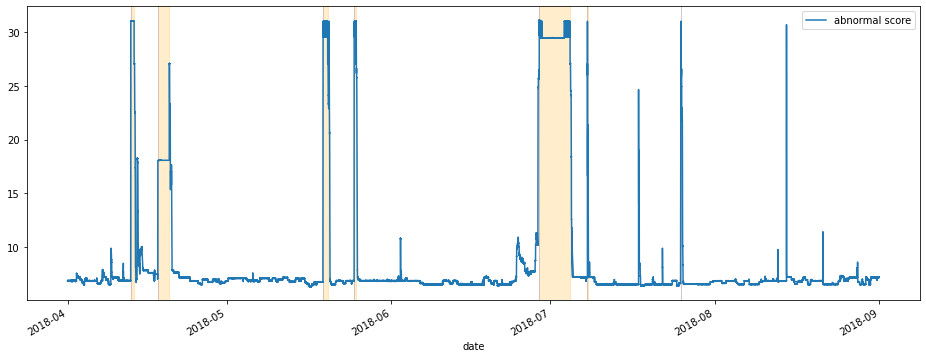

In [30]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['score'].plot(ax=ax)
ax.legend(['abnormal score'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')

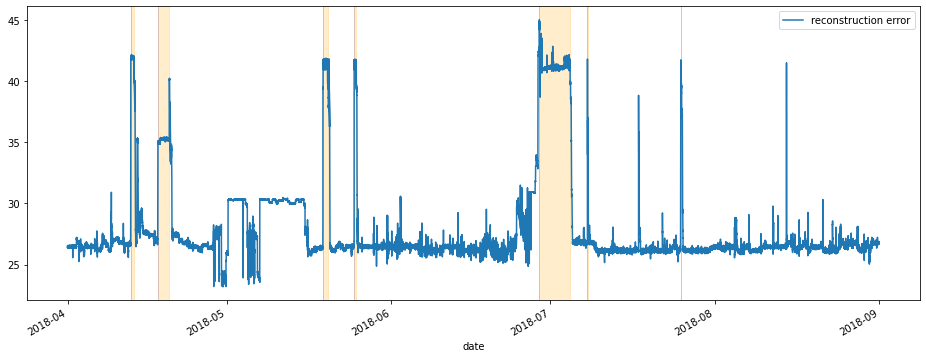

In [31]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['recons_error'].plot(ax=ax)
ax.legend(['reconstruction error'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')